# Figure 3
In this notebook, we reproduce panels from Figure 3. Plots involving experimental data cannot be included, however, as this data is owned by the original authors and can only be distributed with their permission.

We first import the necessary packages, i.e. `NumPy`, `SciPy`, `PyTorch`, and `Matplotlib`.

In [1]:
import numpy as np
import torch
from scipy.stats import binned_statistic, linregress, pearsonr, normaltest, norm, t, kurtosis, ttest_ind, permutation_test, ks_2samp, spearmanr
from scipy.optimize import curve_fit
from scipy.special import erfcinv
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib.offsetbox import DrawingArea, OffsetImage,AnnotationBbox
from matplotlib.legend_handler import HandlerTuple
import matplotlib.colors as mcolors
import matplotlib.font_manager as font_manager

We define some layout settings for the plots and a few other auxiliary variables.

In [2]:
plt.rcParams.update({'pdf.fonttype': 42,
                     'pdf.use14corefonts': False,
                     'ps.useafm': False,
                     'figure.constrained_layout.use': True,
                     'figure.dpi': 150,
                     'font.size': 7,
                     'axes.labelsize': 7,
                     'axes.labelpad': 2,
                     'axes.titlesize': 7,
                     'axes.titlepad': 2,
                     'figure.titlesize': 7,
                     'figure.labelweight': 'light',
                     'figure.titleweight': 'light',
                     'axes.labelweight': 'light',
                     'axes.titleweight': 'light',
                     'font.family': 'sans-serif',
                     'font.sans-serif': 'Helvetica',
                     'font.weight': 'light',
                     'mathtext.fontset': 'custom',
                     'mathtext.it': 'Helvetica:italic',
                     'mathtext.bf': 'Helvetica:bold',
                     'mathtext.sf': 'Helvetica:light',
                     'mathtext.default': 'sf',
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.linewidth': 0.5,
                     'xtick.direction': 'out',
                     'ytick.direction': 'out',
                     'xtick.major.size': 2.5,
                     'xtick.minor.size': 1.5,
                     'ytick.major.size': 2.5,
                     'ytick.minor.size': 1.5,
                     'xtick.major.width': 0.5,
                     'xtick.minor.width': 0.5,
                     'ytick.major.width': 0.5,
                     'ytick.minor.width': 0.5,
                     'xtick.major.pad': 3.5/3,
                     'xtick.minor.pad': 3.5/3,
                     'ytick.major.pad': 3.5/3,
                     'ytick.minor.pad': 3.5/3,
                     'lines.linewidth': 1.,
                     'lines.markersize': 4.,})

# Colors
greens = plt.cm.tab20c(np.array([11,10,9,8]))
purples = plt.cm.Paired(np.array([9,8]))
my_grey = np.ones(3)*0.2
high = np.array(mcolors.to_rgb('black'))
high += 0.2
high = 'black'
low = np.array(mcolors.to_rgb('black'))
low += 0.7
low = 'darkgray'
night = np.array(mcolors.to_rgba('lavender'))
night[3] = 0.4
night_rem = np.array(mcolors.to_rgba('lavender'))
night_rem[3] = 0.8
day = np.array(mcolors.to_rgba('moccasin'))
day[3] = 0.2

mm = 1/2.54/10  # mm in inches
cm = 1/2.54  # cm in inches

Load data files containing the results of simulations. In this case, it's a compressed `NumPy` binary (`.npz`) containing a dictionary with all `PyTorch` tensors.

In [3]:
# wake-sleep simulation
data = np.load('./data/rnn_wake-sleep.npz', allow_pickle=True)['arr_0'].item()
rec_low = data['rec_dict'][200]
rec_high = data['rec_dict'][500]

Compute a few useful parameters:

In [4]:
# some simulation parameters
N = data['params']['N']
f = data['params']['f']
a_low = data['a'][1].item()
M_low = round(a_low*N)
a_high = data['a'][0].item()
M_high = round(a_high*N)

# compute l1-margin
rec_high['syn_margin_mean'] = rec_high['rho_mean'][:,0]*rec_high['l1'].sqrt() * np.sqrt( f*(1-f)/N )
rec_low['syn_margin_mean'] = rec_low['rho_mean'][:,0]*rec_low['l1'].sqrt() * np.sqrt( f*(1-f)/N )

# error vector
p_vec = np.linspace(0, 50-1, 200)/N

# compute number of wake and sleep epochs and their indices in time
n_epochs_wake = data['params']['n_epochs_wake']
n_epochs_sleep = data['params']['n_epochs_sleep']
idx_sleep_low = n_epochs_wake*M_low
idx_sleep_high = n_epochs_wake*M_high

## Network activity during cued recall

In the following cell, we simulate the cued recall of random, low-activity patterns ($f=0.05$) in a recurrent neural network using the weight configuration recorded both **before** and **after** consolidation. We run a few recalls without synaptic noise and the remaining simulation with synaptic noise.

To compare recall performances in a fair way, we scale the weights and thresholds (i.e. $I_\mathrm{inh}$) before-hand, so all neurons have the same average synaptic $u$-values before and after consolidation.

In [5]:
rng = np.random.default_rng(127)

idx_sleep_low = n_epochs_wake*M_low
idx_sleep_high = n_epochs_wake*M_high

theta_pre = rec_high['theta_all'][:,0].clone().numpy()
theta_post = rec_high['theta_all'][:,-1].clone().numpy()
W_pre = rec_high['w'][:,0].reshape(N,N).clone().numpy()
U_pre = np.zeros((N,N,2))
U_pre[:,:,0] = W_pre/(0.6)
U_pre[:,:,1] = 0.6
l2_pre = np.linalg.norm(W_pre, ord=2, axis=1)
l1_pre = np.linalg.norm(W_pre, ord=1, axis=1)
W_post = rec_high['w'][:,-1].reshape(N,N).clone().numpy()
U_post = np.zeros((N,N,2))
U_post[:,:,0] = W_post**0.5
U_post[:,:,1] = W_post**0.5
l2_post = np.linalg.norm(W_post, ord=2, axis=1)
l1_post = np.linalg.norm(W_post, ord=1, axis=1)
Ksi_fam = rec_high['ksi'].clone().numpy()
W_pre_mask = np.heaviside(W_pre - 1e-10, 0)
W_post_mask = np.heaviside(W_post - 1e-10, 0)
U_noise = np.zeros((N,N))

#Scale weights
theta_pre = theta_pre / ( 10*U_pre.sum(axis=(1,2))/(W_pre_mask.sum(axis=1)*2) )**2
U_pre = U_pre / ( 10*U_pre.sum(axis=(1,2))/(W_pre_mask.sum(axis=1)*2) )[:,None,None]

theta_post = theta_post / ( 10*U_post.sum(axis=(1,2))/(W_post_mask.sum(axis=1)*2) )**2
U_post = U_post / ( 10*U_post.sum(axis=(1,2))/(W_post_mask.sum(axis=1)*2) )[:,None,None]

T_tot = 200 # total time steps
T_hold = 10 # cue new pattern every 10 steps
n_neur = 60 # select 60 neurons

# synaptic noise is =0 for the first 50 steps, then >0 
sigma_vec = np.geomspace(3e-2, 3e-2, T_tot)
sigma_vec[:50] = 0

I_mean_pre = (W_pre.sum(axis=1)*f - theta_pre)
I_mean_post = (W_post.sum(axis=1)*f - theta_post)

# pattern recall with pre-consolidation weights
snr_pre = np.zeros((n_neur,T_tot))
spikes_pre = np.zeros((n_neur,T_tot))
for i_t in range(T_tot):
    if i_t%T_hold==0:
        mu = int(i_t/T_hold)
        ksi_mu = Ksi_fam[:,mu:mu+1]
        y_mu = ksi_mu*2 - 1
        S = ksi_mu

    # Synaptic noise
    rng.standard_normal(U_noise.shape, out=U_noise)
    U_noise *= W_pre_mask*sigma_vec[i_t]
    
    W_ = np.clip((U_pre[:,:,0]+U_noise) * U_pre[:,:,1], a_min=0, a_max=None)
    h = (W_@S - theta_pre[:,None])
    S = np.heaviside(h, 0)

    snr_pre[:,i_t] = h[:n_neur,0]
    spikes_pre[:,i_t] = S[:n_neur,0]

# pattern recall with post-consolidation weights
snr_post = np.zeros((n_neur,T_tot))
spikes_post = np.zeros((n_neur,T_tot))
for i_t in range(T_tot):
    if i_t%T_hold==0:
        mu = int(i_t/T_hold)
        ksi_mu = Ksi_fam[:,mu:mu+1]
        y_mu = ksi_mu*2 - 1
        S = ksi_mu
    
    # Synaptic noise
    rng.standard_normal(U_noise.shape, out=U_noise)
    U_noise *= W_post_mask*sigma_vec[i_t]

    W_ = np.clip((U_post[:,:,0]+U_noise) * U_post[:,:,1], a_min=0, a_max=None)
    h = (W_@S - theta_post[:,None])
    S = np.heaviside(h, 0)

    snr_post[:,i_t] = h[:n_neur,0]
    spikes_post[:,i_t] = S[:n_neur,0]


snr_max = snr_post[:,:50].max()
snr_min = np.abs(snr_post[:,:50].min())
snr_post[snr_post>0] = snr_post[snr_post>0] / snr_max
snr_post[snr_post<0] = snr_post[snr_post<0] / snr_min

snr_max = snr_pre[:,:50].max()
snr_min = np.abs(snr_pre[:,:50].min())
snr_pre[snr_pre>0] = snr_pre[snr_pre>0] / snr_max
snr_pre[snr_pre<0] = snr_pre[snr_pre<0] / snr_min

vmin = -1
vmax = 1

### Raster plots
The neural activity is illustrated in a raster plot. This is what the cued recall looks like **before** consolidation, when the network only has undergone few-shot learning to encode all patterns as attractors (with sub-optimal robustness).

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/2135004878.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


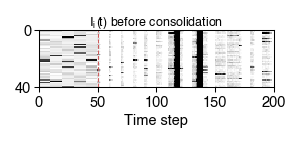

In [6]:
fig = plt.figure(figsize=(4.8*cm, 3.5/1.65*cm))
ax = fig.add_subplot(111)

ax.imshow(snr_pre, aspect='auto', interpolation='none', origin='lower', cmap='Greys', vmin=-1, vmax=1, rasterized=True)

ax.spines['top'].set_visible(1)
ax.spines['right'].set_visible(1)
ax.spines['bottom'].set_visible(1)
ax.spines['left'].set_visible(1)
ax.set_ylim([40, 0])
ax.set_yticks(np.arange(0, n_neur+10, 40))
ax.set_xlim([0, T_tot])
ax.set_xticks(np.arange(0, T_tot+T_hold, T_hold*5))
ax.set_xlabel('Time step')
ax.set_title(r'$\mathit{I_i \,(\!t)}$ before consolidation', size=6)
ax.axvline(50, color='indianred', lw=0.5, ls='--')

fig.show()

The synaptic noise that is injected after 50 time steps clearly disrupts the pattern recall activity. However, **after** consolidation using $z=2$ sub-synaptic components, robustness is optimized and the network can now recall all pattern, even during synaptic noise, as demonstrated in the next raster plot.

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/3581064330.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


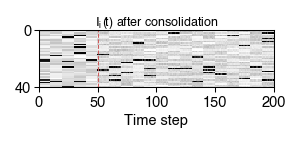

In [7]:
fig = plt.figure(figsize=(4.8*cm, 3.5/1.65*cm))
ax = fig.add_subplot(111)

raster = ax.imshow(snr_post, aspect='auto', interpolation='none', origin='lower', cmap='Greys', vmin=-1, vmax=1, rasterized=True)

ax.spines['top'].set_visible(1)
ax.spines['right'].set_visible(1)
ax.spines['bottom'].set_visible(1)
ax.spines['left'].set_visible(1)
ax.set_ylim([40, 0])
ax.set_yticks(np.arange(0, n_neur+10, 40))
ax.set_xlim([0, T_tot])
ax.set_xticks(np.arange(0, T_tot+T_hold, T_hold*5))
ax.set_xlabel('Time step')
ax.set_title(r'$\mathit{I_i \,(\!t)}$ after consolidation', size=6)
ax.axvline(50, color='indianred', lw=0.5, ls='--')

fig.show()

### Maximal noise tolerance (*supplementary figure*)
The effect of consolidation can be seen in increased tolerance to both neural and synaptic noise.

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/1935464018.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


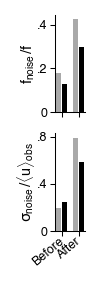

In [8]:
fig = plt.figure(figsize=(1.4*cm, 4.5*cm))

x_vec = np.array([1,2])

tol_bal_high = p_vec[ (rec_high['cap_bal']-0.5).abs().argmin(dim=0).numpy()[[1,3]] ]*2/0.05
tol_syn_high = p_vec[ (rec_high['cap_syn1']-0.5).abs().argmin(dim=0).numpy()[[1,3]] ]*4/0.1
tol_bal_low = p_vec[ (rec_low['cap_bal']-0.5).abs().argmin(dim=0).numpy()[[1,3]] ]*2/0.05
tol_syn_low = p_vec[ (rec_low['cap_syn1']-0.5).abs().argmin(dim=0).numpy()[[1,3]] ]*4/0.1

ax = fig.add_subplot(211)
ax.bar(x_vec+0.17, tol_bal_high, width=0.3, color=high)
ax.bar(x_vec-0.17, tol_bal_low, width=0.3, color=low)
ax.set_xlim([0.6, 2.4])
ax.set_xticks([1,2], [])
ax.set_ylabel(r'$\mathit{f}_{noise} \, / \mathit{f}$', labelpad=0)
ax.set_yticks([0, 0.2, 0.4], [0, '.2', '.4'], size=6)

ax = fig.add_subplot(212)
ax.bar(x_vec+0.17, tol_syn_high, width=0.3, color=high)
ax.bar(x_vec-0.17, tol_syn_low, width=0.3, color=low)
ax.set_xlim([0.6, 2.4])
ax.set_xticks([1,2], ['Before', 'After'], rotation=40, rotation_mode='anchor', ha='right', va='center_baseline', size=6)
ax.set_ylabel(r'$\mathit{\sigma}_{noise} \, / \langle \mathit{u} \rangle_{obs}$', labelpad=0)
ax.set_yticks([0, 0.4, 0.8], [0, '.4', '.8'], size=6)

fig.show()

### Consolidation and pruning over time (*supplementary figure*)
We show how the neural and synaptic SNR increased during the course of consolidation, while connections are pruned.

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/243623064.py:47: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


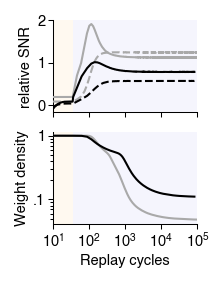

In [9]:
idx_plot_high = np.geomspace(10*M_high, n_epochs_sleep, 2000, dtype=int)
idx_plot_low = np.geomspace(10*M_low, n_epochs_sleep, 2000, dtype=int)

fig = plt.figure(figsize=(3.5*cm, 4.5*cm))
ax = fig.add_subplot(211)
ax.plot(rec_high['t'][idx_plot_high].numpy(), rec_high['margin_mean'][idx_plot_high].numpy(), color=high, zorder=100)
ax.plot(rec_high['t'][idx_plot_high].numpy(), rec_high['syn_margin_mean'][idx_plot_high].numpy()/1.4, ls='--', color=high, zorder=100)
ax.plot(rec_low['t'][idx_plot_low].numpy(), rec_low['margin_mean'][idx_plot_low].numpy(), color=low, zorder=98)
ax.plot(rec_low['t'][idx_plot_low].numpy(), rec_low['syn_margin_mean'][idx_plot_low].numpy()/1.4, ls='--', color=low, zorder=98)
ax.axvspan(xmin=0, xmax=35, ec='none', fc=day, zorder=-100)
ax.axvspan(xmin=35, xmax=1e5, ec='none', fc=night, zorder=-100)

ax.set_xscale('log')
ax.set_xlim([10, n_epochs_sleep])
ax.set_ylim([-0.06, 0.7])
ax.set_yticks([0, 0.35, 0.7], ['0', '1', '2'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'relative SNR')
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5], [])

cap_low = np.trapz(y=rec_low['cap_bal'], x=p_vec, axis=0)/p_vec.max()
cap_high = np.trapz(y=rec_high['cap_bal'], x=p_vec, axis=0)/p_vec.max()
#cap_05e = np.trapz(y=data_05e['cap_bal'], x=data_05e['p'], axis=-1)/data_05e['p'].max()
epoch_vec = torch.tensor([0, 4e1, 5e2, 5e5])
idx_vec_low = (epoch_vec[:,None] - rec_low['t'][None,:]).abs().argmin(dim=1)
idx_vec_high = (epoch_vec[:,None] - rec_high['t'][None,:]).abs().argmin(dim=1)
l0_vec_low = rec_low['l0_mean'][idx_vec_low]
l0_vec_high = rec_high['l0_mean'][idx_vec_high]

ax = fig.add_subplot(212)
ax.plot(rec_high['t'][idx_plot_high].numpy(), rec_high['l0_mean'][idx_plot_high].numpy(), color=high, zorder=100)
ax.plot(rec_low['t'][idx_plot_low].numpy(), rec_low['l0_mean'][idx_plot_low].numpy(), color=low, zorder=98)
ax.axvspan(xmin=0, xmax=35, ec='none', fc=day, zorder=-100)
ax.axvspan(xmin=35, xmax=1e5, ec='none', fc=night, zorder=-100)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim([10, n_epochs_sleep])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'Weight density')
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_yticks([1e-1, 1e0], ['.1', '1'])
ax.set_xlabel('Replay cycles')

fig.show()

### Weight matrices
This is what a subsample of the weights look like **before** consolidation, when only few-shot learning has taken place.

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/2385127080.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


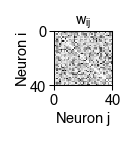

In [10]:
fig = plt.figure(figsize=(2*cm, 3.5/1.65*cm))
ax = fig.add_subplot(111)

ax.imshow(W_pre[:40,:40], aspect='auto', interpolation='none', origin='upper', cmap='Greys', vmin=0, vmax=W_pre[:40,:40].max(), rasterized=True)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_ylim([40, 0])
ax.set_yticks([0, 40])
ax.set_xlim([0, 40])
ax.set_xticks([0, 40])
ax.set_ylabel(r'Neuron $\mathit{i}$', labelpad=0)
ax.set_xlabel(r'Neuron $\mathit{j}$', labelpad=1)
ax.set_title(r'$\mathit{w_{ij}}$', size=7)

fig.show()

And this is what the same subsample of weights look like **after** consolidation with $z=2$ sub-synaptic components.

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/3104989870.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


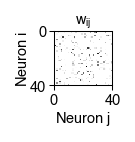

In [11]:
fig = plt.figure(figsize=(2*cm, 3.5/1.65*cm))
ax = fig.add_subplot(111)

ax.imshow(W_post[:40,:40], aspect='auto', interpolation='none', origin='upper', cmap='Greys', vmin=0, vmax=W_post[:40,:40].max(), rasterized=True)

ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.set_ylim([40, 0])
ax.set_yticks([0, 40])
ax.set_xlim([0, 40])
ax.set_xticks([0, 40])
ax.set_ylabel(r'Neuron $\mathit{i}$', labelpad=0)
ax.set_xlabel(r'Neuron $\mathit{j}$', labelpad=1)
ax.set_title(r'$\mathit{w_{ij}}$', size=7)

fig.show()

### Weight correlations and trajectories over time (*supplementary figure*)
During consolidation, sub-synaptic components *within* the same connection become more similar, while sub-synaptic components in different connections remain uncorrelated. We can also follow the trajectories of whole individual weights as consolidation progresses and see how some weights stabilize at high values while other are pruned.

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/1027234554.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


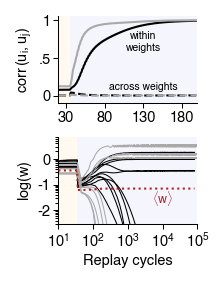

In [12]:
fig = plt.figure(figsize=(3.5*cm, 4.5*cm))

ax = fig.add_subplot(211)

ax.plot(rec_high['t'][idx_sleep_high-15*M_high:idx_sleep_high+1500].numpy(), rec_high['ucorr2'][idx_sleep_high-15*M_high:idx_sleep_high+1500].numpy(), color=high)
ax.plot(rec_high['t'][idx_sleep_high-15*M_high:idx_sleep_high+1500].numpy(), rec_high['ucorr1'][idx_sleep_high-15*M_high:idx_sleep_high+1500].numpy(), color=high, ls='--')

ax.plot(rec_low['t'][idx_sleep_low-15*M_low:idx_sleep_low+1500].numpy(), rec_low['ucorr2'][idx_sleep_low-15*M_low:idx_sleep_low+1500].numpy(), color=low)
ax.plot(rec_low['t'][idx_sleep_low-15*M_low:idx_sleep_low+1500].numpy(), rec_low['ucorr1'][idx_sleep_low-15*M_low:idx_sleep_low+1500].numpy(), color=low, ls='--')

ax.text(130, 0.60, 'within\nweights', ha='center', size=5)
ax.text(130, 0.08, 'across weights', ha='center', size=5)

ax.axvspan(xmin=0, xmax=35, ec='none', fc=day, zorder=-100)
ax.axvspan(xmin=35, xmax=300, ec='none', fc=night, zorder=-100)

ax.set_ylim([-0.1, 1.05])
ax.set_yticks([0, 0.5, 1], [0, '.5', 1])

ax.set_xlim([20, 200])
ax.set_xticks([30, 80, 130, 180])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'$corr\,( \it{u_i}, \it{u_j} )$')

ax = fig.add_subplot(212)
ax.plot(rec_high['t'][idx_plot_high].numpy(), rec_high['l1'][idx_plot_high].numpy()/N, color='firebrick', ls=':', zorder=200)
ax.plot(rec_high['t'][idx_plot_high].numpy(), rec_high['w_on'][:,idx_plot_high].numpy().T, color=high, lw=0.5)
ax.plot(rec_low['t'][idx_plot_low].numpy(), rec_low['w_on'][:3,idx_plot_low].numpy().T, color=low, lw=0.5)
ax.plot(rec_low['t'][idx_plot_low].numpy(), rec_low['w_off'][:5,idx_plot_low].numpy().T, color=low, lw=0.5)

ax.text(1e4, 0.018, r'$\langle w \rangle$', ha='center', size=6, color='firebrick')

ax.axvspan(xmin=0, xmax=35, ec='none', fc=day, zorder=-100)
ax.axvspan(xmin=35, xmax=1e5, ec='none', fc=night, zorder=-100)

ax.set_yscale('log')
ax.set_ylim([3e-3, 7e0])
ax.set_yticks([1e-2, 1e-1, 1e0], [-2, -1, 0])

ax.set_xscale('log')
ax.set_xlim([25, n_epochs_sleep])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'$log(\it{w})$')
ax.set_xticks([1e1, 1e2, 1e3, 1e4, 1e5])
ax.set_xlabel('Replay cycles')

fig.show()

## Weight distribution before and after consolidation

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/2406091627.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


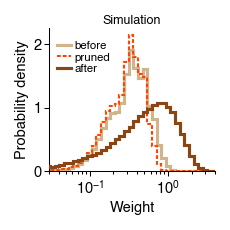

In [13]:
no_diag_mask = torch.eye(N).flatten() < 1

# take weight matrices at different points in time and separate pruned ones
w_pre = rec_high['w'][no_diag_mask,0].numpy()
w_100 = rec_high['w'][no_diag_mask,1].numpy() # 100 steps
w_500 = rec_high['w'][no_diag_mask,2].numpy() # 500 steps
w_post = rec_high['w'][no_diag_mask,-1].numpy() # final stage, 10^5 steps
w_pruned_100 = w_pre[(w_100<=1e-10)]
w_pruned_500 = w_pre[(w_500<=1e-10)]
w_pruned_high = w_pre[(w_post<=1e-10)]
w_pre_high = w_pre[w_pre>1e-4] # for visualization
w_post_high = w_post[w_post>1e-4] # for visualization

# plots
fig = plt.figure(figsize=(3.6*cm, 3.6*cm))

ax = fig.add_subplot(111)
hist_vals, hist_edges = np.histogram(w_pre_high, bins=np.geomspace(w_post_high.min(), w_post_high.max(), 80))
dx = np.diff(np.log10(hist_edges))[0]
ax.stairs(hist_vals/np.trapz(hist_vals, dx=dx), hist_edges, color='tan', label='before', linewidth=1.5, zorder=1)

hist_vals, hist_edges = np.histogram(w_pruned_high, bins=np.geomspace(w_post_high.min(), w_post_high.max(), 80))
dx = np.diff(np.log10(hist_edges))[0]
ax.stairs(hist_vals/np.trapz(hist_vals, dx=dx), hist_edges, color='orangered', label='pruned', linestyle=(0,(1.8,1)), zorder=2)

hist_vals, hist_edges = np.histogram(w_post_high, bins=np.geomspace(w_post_high.min(), w_post_high.max(), 80))
dx = np.diff(np.log10(hist_edges))[0]
ax.stairs(hist_vals/np.trapz(hist_vals, dx=dx), hist_edges, color='saddlebrown', label='after', linewidth=1.5, zorder=3)

ax.set_xscale('log')
ax.set_xlim([0.03, 4])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'Probability density')
ax.set_yticks([0, 1, 2])

handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor(), ls=h.get_linestyle(), lw=h.get_linewidth()) for h in handles[1:]]
handles[1:] = new_handles
ax.legend(handles=handles, labels=labels, loc=[0.02, 0.65], fontsize=5.5, frameon=False, labelspacing=0.1, handletextpad=0.3, handlelength=1.2)
ax.set_xlabel('Weight')
ax.set_title('Simulation', size=6)

fig.show()

## Pruning probability vs. initial weight

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2683/237053182.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


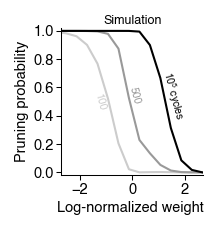

In [14]:
fig = plt.figure(figsize=(3.4*cm, 3.6*cm))
ax = fig.add_subplot(111)

n_bin = 40
bin_equal_high = np.geomspace(w_pre_high.min(), w_pre_high.max(), n_bin+1)
bin_middle_high = (bin_equal_high[:-1] + bin_equal_high[1:])/2

num_pre_high, _, _ = binned_statistic(w_pre_high, w_pre_high, bins=bin_equal_high, statistic='count')
num_pruned_high, _, _ = binned_statistic(w_pruned_high, w_pruned_high, bins=bin_equal_high, statistic='count')
num_pruned_100, _, _ = binned_statistic(w_pruned_100, w_pruned_100, bins=bin_equal_high, statistic='count')
num_pruned_500, _, _ = binned_statistic(w_pruned_500, w_pruned_500, bins=bin_equal_high, statistic='count')

ax.plot(((np.log10(bin_middle_high)-np.log10(w_pre_high).mean())/np.log10(w_pre_high).std()), num_pruned_100/num_pre_high, c=np.ones(3)*0.8)
ax.plot(((np.log10(bin_middle_high)-np.log10(w_pre_high).mean())/np.log10(w_pre_high).std()), num_pruned_500/num_pre_high, c=np.ones(3)*0.6)
ax.plot(((np.log10(bin_middle_high)-np.log10(w_pre_high).mean())/np.log10(w_pre_high).std()), num_pruned_high/num_pre_high, c=high)

ax.text(-1.4, 0.55, '100', size=5, color=np.ones(3)*0.8, rotation=-75, rotation_mode='anchor')
ax.text(-.1, 0.6, '500', size=5, color=np.ones(3)*0.6, rotation=-75, rotation_mode='anchor')
ax.text(1.15, 0.7, r'$10^5$ cycles', size=5, color=high, rotation=-75, rotation_mode='anchor')

ax.set_xlim([-2.7, 2.7])
ax.set_xticks([-2, 0, 2])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([-0.02, 1.02])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel(r'Pruning probability')
ax.set_xlabel('Log-normalized weight', loc='right')
ax.set_title('Simulation', size=6)

fig.show()

## Connection probability vs. neural correlation

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2854/97360317.py:32: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


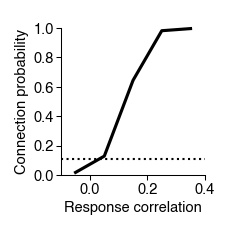

In [43]:
rng = np.random.default_rng(123)
no_diag_mask = torch.eye(N).flatten() < 1

theta_pre = rec_high['theta_all'][:,0].numpy()
theta_post = rec_high['theta_all'][:,1].numpy()
W_pre = rec_high['w'][:,0].reshape(N,N).numpy()
W_post = rec_high['w'][:,-1].reshape(N,N).numpy()
Ksi_fam = rec_high['ksi'].clone().numpy()
Ksi_nov = rng.permuted(np.repeat(Ksi_fam, repeats=5, axis=1), axis=0)

I_fam = (W_post @ Ksi_fam)
w_post = W_post.flatten()[no_diag_mask]
corr_fam = np.corrcoef(I_fam).flatten()[no_diag_mask]
bin_vec = np.arange(-0.1, 0.5, 0.1)
bin_mid = (bin_vec[:-1] + bin_vec[1:])/2
conn_corr_fam, _, _ = binned_statistic(corr_fam, np.heaviside(w_post-1e-10, 0), bins=bin_vec, statistic='mean')

fig = plt.figure(figsize=(3.6*cm, 3.6*cm))
ax = fig.add_subplot(111)

ax.axhline(np.heaviside(w_post-1e-10, 0).mean(), c='k', linestyle=':', zorder=-10)
ax.plot(bin_mid, conn_corr_fam, c='k', zorder=2, label='Simulation', lw=1.5, clip_on=False)

ax.set_xlim([-0.1, 0.4])
ax.set_xticks([0, 0.2, 0.4])
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_ylim([0, 1])
ax.set_ylabel(r'Connection probability')
ax.set_xlabel('Response correlation')
ax.set_title(' ', size=6)

fig.show()

## Connection strength vs. neural correlation

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2854/547474505.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


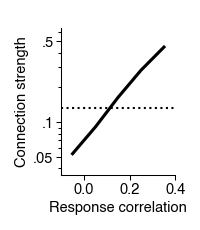

In [42]:
rng = np.random.default_rng(123)
no_diag_mask = torch.eye(N).flatten() < 1

theta_pre = rec_high['theta_all'][:,0].numpy()
theta_post = rec_high['theta_all'][:,1].numpy()
W_pre = rec_high['w'][:,0].reshape(N,N).numpy()
W_post = rec_high['w'][:,-1].reshape(N,N).numpy()
Ksi_fam = rec_high['ksi'].clone().numpy()

I_fam = (W_post @ Ksi_fam)
w_post = W_post.flatten()[no_diag_mask]
conn_mask = (w_post>1e-10)

corr_fam = np.corrcoef(I_fam).flatten()[no_diag_mask]
bin_vec_w = np.arange(-0.1, 0.5, 0.1)
bin_mid_w = (bin_vec_w[:-1] + bin_vec_w[1:])/2
w_corr_fam, _, _ = binned_statistic(corr_fam[conn_mask], w_post[conn_mask], bins=bin_vec_w, statistic='mean')

fig = plt.figure(figsize=(3.1*cm, 3.6*cm))
ax = fig.add_subplot(111)
ax.axhline(w_post[conn_mask].mean()/np.nanmax(w_post[conn_mask]), c='k', linestyle=':', zorder=-10)
ax.plot(bin_mid_w, w_corr_fam/np.nanmax(w_post[conn_mask]), c='k', label='Weight', zorder=2, clip_on=False, lw=1.5)

ax.set_yscale('log')
ax.set_xlim([-0.1, 0.4])
ax.set_xticks([0, 0.2, 0.4])
ax.set_yticks([0.05, 0.1, 0.5], ['.05', '.1', '.5'])
ax.set_ylim([0.035, 0.65])
ax.set_ylabel(r'Connection strength')
ax.set_xlabel('Response correlation')
ax.set_title(' ', size=6)

fig.show()

## Stimulus tuning curves and stimulus selectivity

We define a function to calculate the neural stimulus selectivity (sparseness across neurons or patterns, depending on the `axis` variable). We also define a standard sigmoidal activation function.

In [46]:
def get_selectivity(x, axis):
    n = x.shape[axis]
    A = (x.mean(axis=axis)**2)/((x**2).mean(axis=axis))
    return (1-A)/(1-1/n)

def sigmoid(x, beta=1):
    return 1/(1 + np.exp(-beta*x))

We first compute neural input currents during recall of all patterns. We then use this to compute the z-scored input currents (the stimulus tuning curves) and the stimulus selectivities.

In [47]:
rng = np.random.default_rng(123)

theta_pre = rec_high['theta_all'][:,0].numpy()
theta_post = rec_high['theta_all'][:,-1].numpy()
W_pre = rec_high['w'][:,0].reshape(N,N).numpy()
W_post = rec_high['w'][:,-1].reshape(N,N).numpy()
Ksi_fam = rec_high['ksi'].clone().numpy()
Ksi_nov = rng.permuted(Ksi_fam, axis=0)

# input currents to the consolidated (familiar) patterns
inp_fam_pre = (W_pre @ Ksi_fam)
inp_fam_post = (W_post @ Ksi_fam)
inp_fam_post_soft = sigmoid(inp_fam_post - theta_post[:,None], 0.45)
inp_fam_post_hard = sigmoid(inp_fam_post - theta_post[:,None], 0.6)

# input currents to novel (unseen) patterns
inp_nov_pre = (W_pre @ Ksi_nov) 
inp_nov_post = (W_post @ Ksi_nov)
inp_nov_post_soft = sigmoid(inp_nov_post - theta_post[:,None], 0.45)
inp_nov_post_hard = sigmoid(inp_nov_post - theta_post[:,None], 0.6)

# z-scored input currents
inp_fam_post_Z = (inp_fam_post - inp_fam_post.mean(axis=1)[:,None])/inp_fam_post.std(axis=1)[:,None]
inp_nov_post_Z = (inp_nov_post - inp_fam_post.mean(axis=1)[:,None])/inp_fam_post.std(axis=1)[:,None]

# stimulus selectivity
sel_fam_post_high = get_selectivity((inp_fam_post), axis=1)
sel_fam_post_high_soft = get_selectivity((inp_fam_post_soft), axis=1)
sel_fam_post_high_hard = get_selectivity((inp_fam_post_hard), axis=1)
sel_nov_post_high = get_selectivity((inp_nov_post), axis=1)
sel_nov_post_high_soft = get_selectivity((inp_nov_post_soft), axis=1)
sel_nov_post_high_hard = get_selectivity((inp_nov_post_hard), axis=1)

Plot the stimulus tuning curves (input currents vs. stimulus rank).

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2854/362496857.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


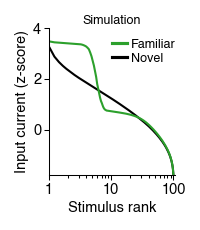

In [48]:
fig = plt.figure(figsize=(3.1*cm, 3.6*cm))
ax = fig.add_subplot(111)

stim_rank = np.linspace(100,1,440)
ax.plot(stim_rank, np.sort(inp_fam_post_Z,axis=1).mean(axis=0), c='tab:green', zorder=1, label='Familiar', lw=1.)
ax.plot(stim_rank, np.sort(inp_nov_post_Z, axis=1).mean(axis=0), c='k', zorder=-1, label='Novel', lw=1.)

new_handles = [Line2D([], [], c='tab:green', ls='-', lw=1.5),
               Line2D([], [], c='k', ls='-', lw=1.5)]
new_labels = ['Familiar', 'Novel']
ax.legend(handles=new_handles, labels=new_labels, loc=[0.5,0.75], fontsize=6, frameon=False, labelspacing=0.1, handletextpad=0.3, handlelength=1.2, handleheight=1, borderpad=0, borderaxespad=0.5)

ax.set_xscale('log')
ax.set_xlim([1, 105])
ax.set_xticks([1, 10, 100], ['1', '10', '100'])
ax.set_ylim([-1.8, 4])
ax.set_xlabel('Stimulus rank')
ax.set_ylabel('Input current (z-score)')
ax.set_title('Simulation', size=6)

fig.show()

Plot stimulus selectivity (sparseness for novel and familiar patterns).

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2854/1836082335.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


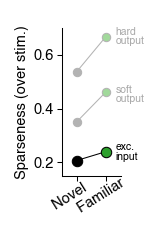

In [49]:
fig = plt.figure(figsize=(2.4*cm, 3.6*cm))
ax = fig.add_subplot(111)

x_vec = np.arange(2)

ax.errorbar(x_vec[1], sel_fam_post_high.mean(), yerr=sel_fam_post_high.std()/np.sqrt(N), marker='o', capsize=2, color=high, mfc='tab:green', zorder=1, mew=0.5, lw=0.5, markersize=5.)
ax.errorbar(x_vec[1], sel_fam_post_high_soft.mean(), yerr=sel_fam_post_high_soft.std()/np.sqrt(N), marker='o', capsize=2, color=np.ones(3)*0.7, mfc=greens[1], zorder=1, mew=0.5, lw=0.5, markersize=4.)#, capsize=2, markersize=3., lw=0.75, mew=0.75)
ax.errorbar(x_vec[1], sel_fam_post_high_hard.mean(), yerr=sel_fam_post_high_hard.std()/np.sqrt(N), marker='o', capsize=2, color=np.ones(3)*0.7, mfc=greens[1], zorder=1, mew=0.5, lw=0.5, markersize=4.)#, capsize=2, markersize=3., lw=0.75, mew=0.75)

ax.errorbar(x_vec[0], sel_nov_post_high.mean(), yerr=sel_nov_post_high.std()/np.sqrt(N), marker='o', capsize=2, color=high, zorder=1, mew=0.5, lw=0.5, markersize=5.)
ax.errorbar(x_vec[0], sel_nov_post_high_soft.mean(), yerr=sel_nov_post_high_soft.std()/np.sqrt(N), marker='o', capsize=2, color=np.ones(3)*0.7, zorder=1, mew=0.5, lw=0.5, markersize=4.)#, capsize=2, markersize=3., lw=0.75, mew=0.75)
ax.errorbar(x_vec[0], sel_nov_post_high_hard.mean(), yerr=sel_nov_post_high_hard.std()/np.sqrt(N), marker='o', capsize=2, color=np.ones(3)*0.7, zorder=1, mew=0.5, lw=0.5, markersize=4.)#, capsize=2, markersize=3., lw=0.75, mew=0.75)

ax.plot(x_vec, [sel_nov_post_high.mean(), sel_fam_post_high.mean()], c=high, lw=0.5, zorder=-10)
ax.plot(x_vec, [sel_nov_post_high_soft.mean(), sel_fam_post_high_soft.mean()], c=np.ones(3)*0.7, lw=0.5, zorder=-10)
ax.plot(x_vec, [sel_nov_post_high_hard.mean(), sel_fam_post_high_hard.mean()], c=np.ones(3)*0.7, lw=0.5, zorder=-10)

ax.set_xlim([-0.5, 1.5])
ax.tick_params(axis='both', which='major', pad=1.5)
ax.set_xticks([0, 1], ['Novel      ', 'Familiar     '], rotation=32, ha='center', va='top', rotation_mode='anchor', fontsize=7)
ax.set_ylim([0.15, 0.7])
ax.set_ylabel('Sparseness (over stim.)')
ax.set_title(' ', size=6)

ax.text(1.32, sel_fam_post_high.mean(), 'exc.\ninput', color='k', size=5, va='center', linespacing=0.95)
ax.text(1.32, sel_fam_post_high_soft.mean()-0.01, 'soft\noutput', color='darkgray', size=5, va='center', linespacing=0.95)
ax.text(1.32, sel_fam_post_high_hard.mean()+0.0, 'hard\noutput', color='darkgray', size=5, va='center', linespacing=0.95)

fig.show()

## Improvement in SNR vs. initial SNR

We first plot the change in SNR at different stages of the consolidation process, i.e. after varying numbers of pattern replay cycles.

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2854/2794571493.py:52: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


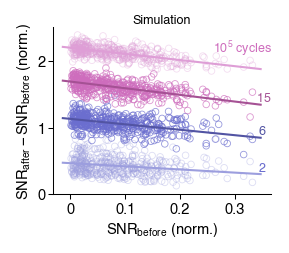

In [50]:
# colors
many = plt.cm.tab20b(np.arange(16, 20))
mid = plt.cm.tab20b(np.arange(0, 4))
few = plt.cm.tab20c(np.arange(12, 20))

# plot
fig = plt.figure(figsize=(4.6*cm, 4.*cm))
ax = fig.add_subplot(111)
ax.scatter(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,2]-rec_high['radius_min'][:,0]).flatten().numpy(), facecolor='none', edgecolor=mid[3], alpha=0.5*0.7, marker='o', s=10, lw=0.4)
ax.scatter(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,6]-rec_high['radius_min'][:,0]).flatten().numpy(), facecolor='none', edgecolor=mid[2], alpha=1.0*0.7, marker='o', s=10, lw=0.4)
ax.scatter(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,15]-rec_high['radius_min'][:,0]).flatten().numpy(), facecolor='none', edgecolor=many[2], alpha=1.0*0.7, marker='o', s=10, lw=0.4)
ax.scatter(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,-1]-rec_high['radius_min'][:,0]).flatten().numpy(), facecolor='none', edgecolor=many[3], alpha=0.5*0.7, marker='o', s=10, lw=0.4)

regr_few = linregress(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,2]-rec_high['radius_min'][:,0]).flatten().numpy())
regr_mid = linregress(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,6]-rec_high['radius_min'][:,0]).flatten().numpy())
regr_many = linregress(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,15]-rec_high['radius_min'][:,0]).flatten().numpy())
regr_all = linregress(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,-1]-rec_high['radius_min'][:,0]).flatten().numpy())
x = np.linspace(rec_high['radius_min'][:,0].min().numpy()-0.0015, rec_high['radius_min'][:,0].max().numpy()+0.0015, 100)
y_few = regr_few.slope*x + regr_few.intercept
y_mid = regr_mid.slope*x + regr_mid.intercept
y_many = regr_many.slope*x + regr_many.intercept
y_all = regr_all.slope*x + regr_all.intercept
ax.plot(x, y_few, c=mid[3])
ax.plot(x, y_mid, c=mid[1])
ax.plot(x, y_many, c=many[1])
ax.plot(x, y_all, c=many[3])

corr_few = pearsonr(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,2]-rec_high['radius_min'][:,0]).flatten().numpy())
corr_mid = pearsonr(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,6]-rec_high['radius_min'][:,0]).flatten().numpy())
corr_many = pearsonr(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,15]-rec_high['radius_min'][:,0]).flatten().numpy())
corr_all = pearsonr(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,-1]-rec_high['radius_min'][:,0]).flatten().numpy())

new_handles = [Line2D([], [], c=many[3], lw=1.5),
               Line2D([], [], c=many[2], lw=1.5),
               Line2D([], [], c=mid[2], lw=1.5),
               Line2D([], [], c=few[2], lw=1.5)]
new_labels = [r'$10^6$ cycles', r'$10^2$ cycles', r'$25 \;\,$ cycles', r'$2 \;\;\,$  cycles']

ax.text(x[-2], y_few[-1]+0.005, '2 ', c=mid[2], size=6)
ax.text(x[-2], y_mid[-1]+0.005, '6 ', c=mid[1], size=6)
ax.text(x[-3], y_many[-2]+0.005, '15 ', c=many[1], size=6)
ax.text(x[-1]+0.002, y_all[-1]+0.025, r'$10^5$ cycles', c=many[2], size=6, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 0.01, 0.02, 0.03], [0, 0.1, 0.2, 0.3])
ax.set_yticks([0., 0.1, 0.2], [0, 1, 2])
ax.set_xlabel(r'$SNR_{before}$ (norm.)')
ax.set_ylabel(r'$SNR_{after} - SNR_{before}$ (norm.)')
ax.set_title('Simulation', size=6)

fig.show()

Next, we plot the final change in SNR (at the end of consolidation) for a network with relatively low storage load ($\alpha = 0.20$) and a network with higher storage load ($\alpha = 0.44$).

/var/folders/zw/97zkf2ps7tvc9t7jcj25pv0w0000gn/T/ipykernel_2854/2145884303.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


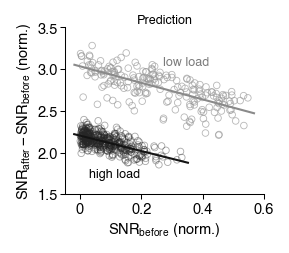

In [55]:
# colors
high = np.ones(3)*0.15
low = np.ones(3)*0.6

# plot
fig = plt.figure(figsize=(4.6*cm, 4.*cm))
ax = fig.add_subplot(111)
ax.scatter(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,-1]-rec_high['radius_min'][:,0]).flatten().numpy(), facecolor='none', edgecolor=high, alpha=0.4, marker='o', s=10, lw=0.4)
ax.scatter(rec_low['radius_min'][:,0].numpy(), (rec_low['radius_min'][:,-1]-rec_low['radius_min'][:,0]).flatten().numpy(), facecolor='none', edgecolor=low, alpha=0.7, marker='o', s=10, lw=0.4)

regr_high = linregress(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,-1]-rec_high['radius_min'][:,0]).flatten().numpy())
regr_low = linregress(rec_low['radius_min'][:,0].numpy(), (rec_low['radius_min'][:,-1]-rec_low['radius_min'][:,0]).flatten().numpy())
x_high = np.linspace(rec_high['radius_min'][:,0].min().numpy()-0.002, rec_high['radius_min'][:,0].max().numpy()+0.002, 10)
x_low = np.linspace(rec_low['radius_min'][:,0].min().numpy()-0.002, rec_low['radius_min'][:,0].max().numpy()+0.002, 10)
y_high = regr_high.slope*x_high + regr_high.intercept
y_low = regr_low.slope*x_low + regr_low.intercept
ax.plot(x_high, y_high, c=high*0.5)
ax.plot(x_low, y_low, c=low*0.9)

corr_high = pearsonr(rec_high['radius_min'][:,0].numpy(), (rec_high['radius_min'][:,-1]-rec_high['radius_min'][:,0]).flatten().numpy())
corr_low = pearsonr(rec_low['radius_min'][:,0].numpy(), (rec_low['radius_min'][:,-1]-rec_low['radius_min'][:,0]).flatten().numpy())

new_handles = [Line2D([], [], c=low, lw=0.6, ls='-', marker='o', mfc='none', mew=0.6, markersize=3.5),
               Line2D([], [], c=high, lw=0.6, ls='-', marker='o', mfc='none', mew=0.6, markersize=3.5)]
new_labels = [r'low load', r'high load']

ax.text(0.003, 0.17, 'high load', color='k', size=6)
ax.text(0.027, 0.305, 'low load', color=low*0.8, size=6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([0, 0.02, 0.04, 0.06], [0, 0.2, 0.4, 0.6])
ax.set_ylim([0.15, 0.35])
ax.set_yticks([0.15, 0.2, 0.25, 0.3, 0.35], [1.5, 2.0, 2.5, 3.0, 3.5])
ax.set_xlabel(r'$SNR_{before}$ (norm.)')
ax.set_ylabel(r'$SNR_{after} - SNR_{before}$ (norm.)')
ax.set_title('Prediction', y=1, size=6)

fig.show()